# Time Series Classification

## Import Package

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import statistics as stat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from patsy import dmatrices
import statsmodels.discrete.discrete_model as sm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

## Pro-processing data

### Upload data

In [2]:
directories=os.listdir('Dataset') #os.listdir(path)---list files of this path
directories=directories[1:]  #delete '.DS_Store' file
data_dict={}

for directory in directories:
    files=os.listdir('Dataset/' + directory)
    for file in files:
        if directory=='bending2' and file=='dataset4.csv':
            new_name=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','vg_rss23','ar_rss23','delete']
            df=pd.read_csv('Dataset/' + directory + '/' + file, sep=' ',names=new_name,skiprows=5)
            df=df.drop(['delete'],axis=1)
            data_dict[directory + '_' + file]=df
        else:
            new_name=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','vg_rss23','ar_rss23']
            df=pd.read_csv('Dataset/' + directory + '/' + file, names=new_name,skiprows=5)
            data_dict[directory + '_' + file]=df

data_dict

{'bending1_dataset7.csv':        time  avg_rss12  var_rss12  avg_rss13  var_rss13  vg_rss23  ar_rss23
 0         0      42.00       0.00      18.50       0.50     12.00      0.00
 1       250      42.00       0.00      18.00       0.00     11.33      0.94
 2       500      42.75       0.43      16.75       1.79     18.25      0.43
 3       750      42.50       0.50      16.75       0.83     19.00      1.22
 4      1000      43.00       0.82      16.25       0.83     18.00      0.00
 5      1250      43.67       0.47      12.75       0.83     19.00      0.82
 6      1500      43.50       0.50      12.00       0.00     19.75      0.43
 7      1750      43.50       0.50      13.75       0.83     18.50      0.50
 8      2000      43.33       0.47      15.33       0.47     20.50      0.50
 9      2250      43.50       0.50      18.00       1.87     20.50      0.87
 10     2500      43.50       0.50      18.50       0.50     19.50      1.66
 11     2750      43.75       0.83      19.67      

### Split training and test data

In [3]:
test_list=['bending1_dataset1.csv','bending1_dataset2.csv','bending2_dataset1.csv','bending2_dataset2.csv','cycling_dataset1.csv','cycling_dataset2.csv','cycling_dataset3.csv','walking_dataset1.csv','walking_dataset2.csv','walking_dataset3.csv','sitting_dataset1.csv','sitting_dataset2.csv','sitting_dataset3.csv','standing_dataset1.csv','standing_dataset2.csv','standing_dataset3.csv','lying_dataset1.csv','lying_dataset2.csv','lying_dataset3.csv']
test_dict={}
train_dict={}
for file,contet in data_dict.items():
    if file in test_list:
        test_dict[file]=contet
    else:
        train_dict[file]=contet

test_dict,train_dict

({'bending1_dataset1.csv':        time  avg_rss12  var_rss12  avg_rss13  var_rss13  vg_rss23  ar_rss23
  0         0      39.25       0.43      22.75       0.43     33.75      1.30
  1       250      39.25       0.43      23.00       0.00     33.00      0.00
  2       500      39.25       0.43      23.25       0.43     33.00      0.00
  3       750      39.50       0.50      23.00       0.71     33.00      0.00
  4      1000      39.50       0.50      24.00       0.00     33.00      0.00
  5      1250      39.25       0.43      24.00       0.00     33.00      0.00
  6      1500      39.25       0.43      24.00       0.00     33.00      0.00
  7      1750      39.00       0.00      23.75       0.43     33.00      0.00
  8      2000      39.50       0.50      24.00       0.00     33.00      0.00
  9      2250      39.50       0.50      23.00       0.00     33.00      0.00
  10     2500      39.50       0.50      23.25       0.43     33.00      0.00
  11     2750      39.50       0.50    

### Feature Extraction

#### Answer: minmum,maxmum,mean,median,standard deviation,fist quartile,third quartile

#### extract the time-domain features of 6 time series in each instance

In [4]:
time_domain_features=pd.DataFrame(columns=['Instance',
                                           'min1','max1','mean1','median1','std1','1st_quart1','3rd_quart1',
                                           'min2','max2','mean2','median2','std2','1st_quart2','3rd_quart2',
                                           'min3','max3','mean3','median3','std3','1st_quart3','3rd_quart3',
                                           'min4','max4','mean4','median4','std4','1st_quart4','3rd_quart4',
                                           'min5','max5','mean5','median5','std5','1st_quart5','3rd_quart5',
                                           'min6','max6','mean6','median6','std6','1st_quart6','3rd_quart6'],index=range(1,89))
time_domain_features['Instance']=range(1,89)
time_domain_features.set_index(['Instance'], inplace=True) #set specify column as index

#change order like we can see
keys=['bending1_dataset1.csv','bending1_dataset2.csv','bending1_dataset3.csv','bending1_dataset4.csv','bending1_dataset5.csv','bending1_dataset6.csv','bending1_dataset7.csv',
      'bending2_dataset1.csv','bending2_dataset2.csv','bending2_dataset3.csv','bending2_dataset4.csv','bending2_dataset5.csv','bending2_dataset6.csv',
      'cycling_dataset1.csv','cycling_dataset2.csv','cycling_dataset3.csv','cycling_dataset4.csv','cycling_dataset5.csv','cycling_dataset6.csv','cycling_dataset7.csv','cycling_dataset8.csv','cycling_dataset9.csv','cycling_dataset10.csv','cycling_dataset11.csv','cycling_dataset12.csv','cycling_dataset13.csv','cycling_dataset14.csv','cycling_dataset15.csv',
      'lying_dataset1.csv','lying_dataset2.csv','lying_dataset3.csv','lying_dataset4.csv','lying_dataset5.csv','lying_dataset6.csv','lying_dataset7.csv','lying_dataset8.csv','lying_dataset9.csv','lying_dataset10.csv','lying_dataset11.csv','lying_dataset12.csv','lying_dataset13.csv','lying_dataset14.csv','lying_dataset15.csv',
      'sitting_dataset1.csv','sitting_dataset2.csv','sitting_dataset3.csv','sitting_dataset4.csv','sitting_dataset5.csv','sitting_dataset6.csv','sitting_dataset7.csv','sitting_dataset8.csv','sitting_dataset9.csv','sitting_dataset10.csv','sitting_dataset11.csv','sitting_dataset12.csv','sitting_dataset13.csv','sitting_dataset14.csv','sitting_dataset15.csv',
      'standing_dataset1.csv','standing_dataset2.csv','standing_dataset3.csv','standing_dataset4.csv','standing_dataset5.csv','standing_dataset6.csv','standing_dataset7.csv','standing_dataset8.csv','standing_dataset9.csv','standing_dataset10.csv','standing_dataset11.csv','standing_dataset12.csv','standing_dataset13.csv','standing_dataset14.csv','standing_dataset15.csv',
      'walking_dataset1.csv','walking_dataset2.csv','walking_dataset3.csv','walking_dataset4.csv','walking_dataset5.csv','walking_dataset6.csv','walking_dataset7.csv','walking_dataset8.csv','walking_dataset9.csv','walking_dataset10.csv','walking_dataset11.csv','walking_dataset12.csv','walking_dataset13.csv','walking_dataset14.csv','walking_dataset15.csv']
i=0
for key in keys: 
    df_values=data_dict[key]
    
    j=0
    for columns in ['avg_rss12','var_rss12','avg_rss13','var_rss13','vg_rss23','ar_rss23']:
        column=df_values[columns]
        
        Min=column.min()
        Max=column.max()
        Mean=column.mean()
        Median=column.median()
        Standard_Deviation=column.std()
        First_quartile=column.quantile(q=0.25)
        Third_quartile=column.quantile(q=0.75)
        
        time_domain_features.iat[i,j]=Min
        j=j+1
        time_domain_features.iat[i,j]=Max
        j=j+1
        time_domain_features.iat[i,j]=Mean
        j=j+1
        time_domain_features.iat[i,j]=Median
        j=j+1
        time_domain_features.iat[i,j]=Standard_Deviation
        j=j+1
        time_domain_features.iat[i,j]=First_quartile
        j=j+1
        time_domain_features.iat[i,j]=Third_quartile
        j=j+1
    i=i+1

time_domain_features

,min1,max1,mean1,median1,std1,1st_quart1,3rd_quart1,min2,max2,mean2,...,std5,1st_quart5,3rd_quart5,min6,max6,mean6,median6,std6,1st_quart6,3rd_quart6
Instance,,,,,,,,,,,,,,,,,,,,,
1,37.25,45,40.6248,40.5,1.47697,39.25,42,0,1.3,0.358604,...,2.18845,33,36,0,1.92,0.570583,0.43,0.582915,0,1.3
2,38,45.67,42.8128,42.5,1.43555,42,43.67,0,1.22,0.372438,...,1.99525,32,34.5,0,3.11,0.571083,0.43,0.60101,0,1.3
3,35,47.4,43.9545,44.33,1.55884,43,45,0,1.7,0.42625,...,1.9996,35.3625,36.5,0,1.79,0.493292,0.43,0.513506,0,0.94
4,33,47.75,42.1798,43.5,3.67067,39.15,45,0,3,0.696042,...,3.84945,30.4575,36.33,0,2.18,0.613521,0.5,0.524317,0,1
5,33,45.75,41.6781,41.75,2.24349,41.33,42.75,0,2.83,0.535979,...,2.41103,28.4575,31.25,0,1.79,0.383292,0.43,0.389164,0,0.5
6,37,48,43.455,43.25,1.3861,42.5,45,0,1.58,0.378083,...,2.48886,22.25,24,0,5.26,0.679646,0.5,0.622534,0.43,0.87
7,36.25,48,43.9691,44.5,1.61836,43.31,44.67,0,1.5,0.413125,...,3.3183,20.5,23.75,0,2.96,0.555313,0.49,0.487826,0,0.83
8,12.75,51,24.563,24.25,3.73751,23.1875,26.5,0,6.87,0.590833,...,3.69379,20.5,27,0,4.97,0.700188,0.5,0.69372,0.43,0.87
9,0,42.75,27.4646,28,3.58358,25.5,30,0,7.76,0.449708,...,5.05364,15,20.75,0,6.76,1.12213,0.83,1.01234,0.47,1.3


#### Estimate time-domian features --- build 90% bootsrap confidence interval for std of each the time-domain features

In [5]:
for column in time_domain_features.columns:
    lst=[]
    for i in range(0,1000):
        samples=time_domain_features[column]
        samples.sample(n=88,replace=True) #use boostrap method to extract sample
        sample_standard_deviation=samples.std()
        lst.append(sample_standard_deviation)
    lst.sort()
    confidence_interval=[np.percentile(lst,0.05),np.percentile(lst,0.95)]    
    print(column,confidence_interval)

min1 [9.569975284512807, 9.569975284512807]
max1 [4.39436168470319, 4.39436168470319]
mean1 [5.3357176583441746, 5.3357176583441746]
median1 [5.440054137152636, 5.440054137152637]
std1 [1.7721533975028407, 1.772153397502841]
1st_quart1 [6.15358972418537, 6.1535897241853705]
3rd_quart1 [5.138924613450998, 5.138924613450999]
min2 [0.0, 0.0]
max2 [5.062729374810639, 5.0627293748106394]
mean2 [1.5741639200745121, 1.5741639200745121]
median2 [1.4122441649745636, 1.4122441649745636]
std2 [0.8841054781862709, 0.884105478186271]
1st_quart2 [0.9463861911256928, 0.9463861911256928]
3rd_quart2 [2.12526640640591, 2.12526640640591]
min3 [2.956462059205819, 2.956462059205819]
max3 [4.875136693954744, 4.875136693954744]
mean3 [4.008380131777648, 4.008380131777648]
median3 [4.036396318784075, 4.036396318784075]
std3 [0.9467102620752954, 0.9467102620752954]
1st_quart3 [4.220657884507629, 4.22065788450763]
3rd_quart3 [4.171628224016796, 4.171628224016796]
min4 [0.0, 0.0]
max4 [2.1836254849723407, 2.1836

<font color=black size=4 face=雅黑>(iv) Answer: three most important time-domain features are Min, Max and Mean</font>

## Fit model

### Binary Classification Using Logistic Rgression

#### scatter plots of features (min,max,mean)

In [6]:
#train set time domain features
df=pd.DataFrame(columns=['Instance',
                         'min1','max1','mean1','median1','std1','1st_quart1','3rd_quart1',
                         'min2','max2','mean2','median2','std2','1st_quart2','3rd_quart2',
                         'min3','max3','mean3','median3','std3','1st_quart3','3rd_quart3',
                         'min4','max4','mean4','median4','std4','1st_quart4','3rd_quart4',
                         'min5','max5','mean5','median5','std5','1st_quart5','3rd_quart5',
                         'min6','max6','mean6','median6','std6','1st_quart6','3rd_quart6'],index=range(1,89))
df['Instance']=range(1,89)
df.set_index(['Instance'], inplace=True) #set specify column as index

#change order 
train_keys=['bending1_dataset3.csv','bending1_dataset4.csv','bending1_dataset5.csv','bending1_dataset6.csv','bending1_dataset7.csv',
            'bending2_dataset3.csv','bending2_dataset4.csv','bending2_dataset5.csv','bending2_dataset6.csv',
            'cycling_dataset4.csv','cycling_dataset5.csv','cycling_dataset6.csv','cycling_dataset7.csv','cycling_dataset8.csv','cycling_dataset9.csv','cycling_dataset10.csv','cycling_dataset11.csv','cycling_dataset12.csv','cycling_dataset13.csv','cycling_dataset14.csv','cycling_dataset15.csv',
            'lying_dataset4.csv','lying_dataset5.csv','lying_dataset6.csv','lying_dataset7.csv','lying_dataset8.csv','lying_dataset9.csv','lying_dataset10.csv','lying_dataset11.csv','lying_dataset12.csv','lying_dataset13.csv','lying_dataset14.csv','lying_dataset15.csv',
            'sitting_dataset4.csv','sitting_dataset5.csv','sitting_dataset6.csv','sitting_dataset7.csv','sitting_dataset8.csv','sitting_dataset9.csv','sitting_dataset10.csv','sitting_dataset11.csv','sitting_dataset12.csv','sitting_dataset13.csv','sitting_dataset14.csv','sitting_dataset15.csv',
            'standing_dataset4.csv','standing_dataset5.csv','standing_dataset6.csv','standing_dataset7.csv','standing_dataset8.csv','standing_dataset9.csv','standing_dataset10.csv','standing_dataset11.csv','standing_dataset12.csv','standing_dataset13.csv','standing_dataset14.csv','standing_dataset15.csv',
            'walking_dataset4.csv','walking_dataset5.csv','walking_dataset6.csv','walking_dataset7.csv','walking_dataset8.csv','walking_dataset9.csv','walking_dataset10.csv','walking_dataset11.csv','walking_dataset12.csv','walking_dataset13.csv','walking_dataset14.csv','walking_dataset15.csv']
i=0
for key in train_keys: 
    df_values=train_dict[key]
    
    j=0
    for columns in ['avg_rss12','var_rss12','avg_rss13','var_rss13','vg_rss23','ar_rss23']:
        column=df_values[columns]
        
        Min=column.min()
        Max=column.max()
        Mean=column.mean()
        Median=column.median()
        Standard_Deviation=column.std()
        First_quartile=column.quantile(q=0.25)
        Third_quartile=column.quantile(q=0.75)
        
        df.iat[i,j]=Min
        j=j+1
        df.iat[i,j]=Max
        j=j+1
        df.iat[i,j]=Mean
        j=j+1
        df.iat[i,j]=Median
        j=j+1
        df.iat[i,j]=Standard_Deviation
        j=j+1
        df.iat[i,j]=First_quartile
        j=j+1
        df.iat[i,j]=Third_quartile
        j=j+1
    i=i+1
df=df[0:69]

#select time series 1, 2, and 6's min,max,mean data from training set
training_time_domain_features=df[['min1','max1','mean1','min2','max2','mean2','min6','max6','mean6']]
training_time_domain_features['bending']=[1]*9+[0]*60 #bending or not bending
training_time_domain_features

,min1,max1,mean1,min2,max2,mean2,min6,max6,mean6,bending
Instance,,,,,,,,,,
1,35,47.4,43.9545,0,1.7,0.42625,0,1.79,0.493292,1
2,33,47.75,42.1798,0,3,0.696042,0,2.18,0.613521,1
3,33,45.75,41.6781,0,2.83,0.535979,0,1.79,0.383292,1
4,37,48,43.455,0,1.58,0.378083,0,5.26,0.679646,1
5,36.25,48,43.9691,0,1.5,0.413125,0,2.96,0.555313,1
6,21,50,32.5862,0,9.9,0.516125,0,13.61,1.16204,1
7,27.5,33,29.8819,0,1,0.256438,0,6.4,0.701625,1
8,19,45.5,30.9381,0,6.4,0.467167,0,6.73,1.10735,1
9,25,47.5,31.0582,0,6.38,0.405458,0,4.92,1.0981,1


                                                scatterplot


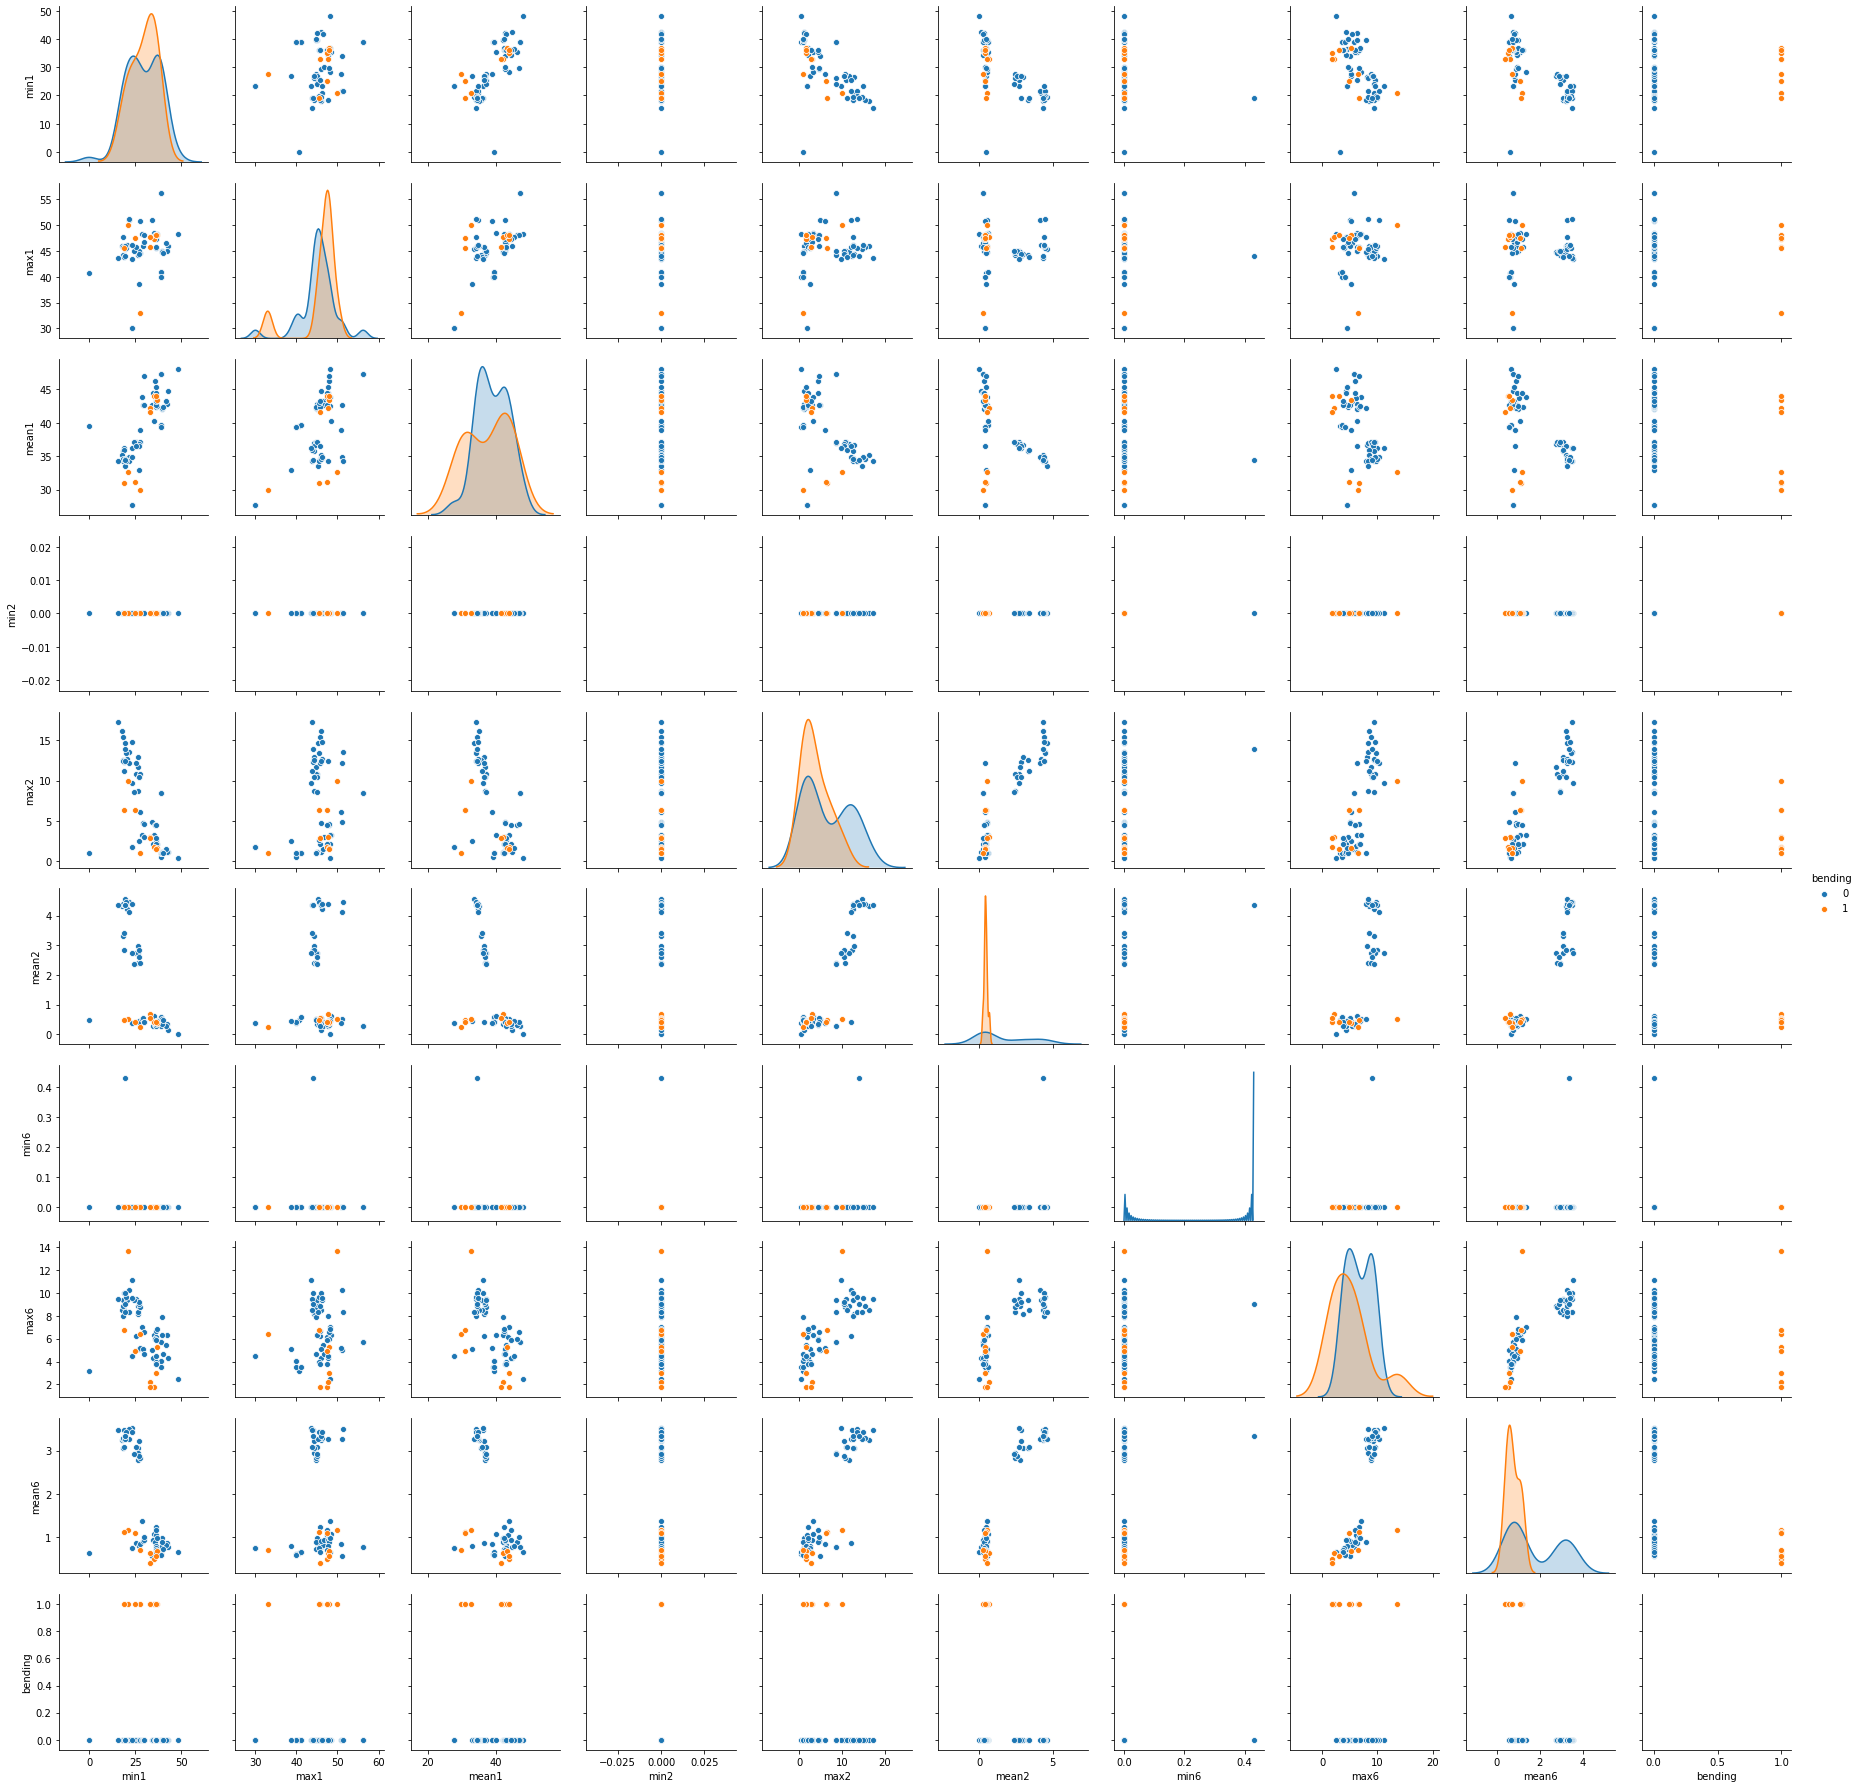

In [7]:
#scatter plot of features (min,max,mean) from time series 1,2,6
sns.pairplot(training_time_domain_features,hue='bending')
print('                                                scatterplot')
plt.show()

#### break each time series in training set into two length time series(6 time series--->12 time series), scatter plots of features (min,max,mean)

In [8]:
#create new training set which break each time series in original training set into two length time series(6 time series---12 time series)
new_train_data_dictionary={}
for key,value in train_dict.items():
    if key=='sitting_dataset8.csv':
        avg_rss12_1=value['avg_rss12']
        avg_rss12_1=avg_rss12_1.head(239)
        avg_rss12_2=value['avg_rss12']
        avg_rss12_2=avg_rss12_2.tail(239)
        
        var_rss12_1=value['var_rss12']
        var_rss12_1=var_rss12_1.head(239)
        var_rss12_2=value['var_rss12']
        var_rss12_2=var_rss12_2.head(239)
        
        avg_rss13_1=value['avg_rss13']
        avg_rss13_1=avg_rss13_1.head(239)
        avg_rss13_2=value['avg_rss13']
        avg_rss13_2=avg_rss13_2.head(239)
        
        var_rss13_1=value['var_rss13']
        var_rss13_1=var_rss13_1.head(239)
        var_rss13_2=value['var_rss13']
        var_rss13_2=var_rss13_2.head(239)
        
        avg_rss23_1=value['vg_rss23']
        avg_rss23_1=avg_rss23_1.head(239)
        avg_rss23_2=value['vg_rss23']
        avg_rss23_2=avg_rss23_2.head(239)
        
        var_rss23_1=value['ar_rss23']
        var_rss23_1=var_rss23_1.head(239)
        var_rss23_2=value['ar_rss23']
        var_rss23_2=var_rss23_2.head(239)
        
    else:
        avg_rss12_1=value['avg_rss12']
        avg_rss12_1=avg_rss12_1.head(240)
        avg_rss12_2=value['avg_rss12']
        avg_rss12_2=avg_rss12_2.tail(240)
        
        var_rss12_1=value['var_rss12']
        var_rss12_1=var_rss12_1.head(240)
        var_rss12_2=value['var_rss12']
        var_rss12_2=var_rss12_2.head(240)
        
        avg_rss13_1=value['avg_rss13']
        avg_rss13_1=avg_rss13_1.head(240)
        avg_rss13_2=value['avg_rss13']
        avg_rss13_2=avg_rss13_2.head(240)
        
        var_rss13_1=value['var_rss13']
        var_rss13_1=var_rss13_1.head(240)
        var_rss13_2=value['var_rss13']
        var_rss13_2=var_rss13_2.head(240)
        
        avg_rss23_1=value['vg_rss23']
        avg_rss23_1=avg_rss23_1.head(240)
        avg_rss23_2=value['vg_rss23']
        avg_rss23_2=avg_rss23_2.head(240)
        
        var_rss23_1=value['ar_rss23']
        var_rss23_1=var_rss23_1.head(240)
        var_rss23_2=value['ar_rss23']
        var_rss23_2=var_rss23_2.head(240)
    
    new_train_data_dictionary[key]=pd.DataFrame({'avg_rss12_1':avg_rss12_1.tolist(),
                                                 'var_rss12_1':var_rss12_1.tolist(),
                                                 'avg_rss13_1':avg_rss13_1.tolist(),
                                                 'var_rss13_1':var_rss13_1.tolist(),
                                                 'vg_rss23_1':avg_rss23_1.tolist(),
                                                 'ar_rss23_1':var_rss23_1.tolist(),
                                                 'avg_rss12_2':avg_rss12_2.tolist(),
                                                 'var_rss12_2':var_rss12_2.tolist(),
                                                 'avg_rss13_2':avg_rss13_2.tolist(),
                                                 'var_rss13_2':var_rss13_2.tolist(),
                                                 'vg_rss23_2':avg_rss23_2.tolist(),
                                                 'ar_rss23_2':var_rss23_2.tolist()})
new_train_data_dictionary

{'bending1_dataset7.csv':      avg_rss12_1  var_rss12_1  avg_rss13_1  var_rss13_1  vg_rss23_1  \
 0          42.00         0.00        18.50         0.50       12.00   
 1          42.00         0.00        18.00         0.00       11.33   
 2          42.75         0.43        16.75         1.79       18.25   
 3          42.50         0.50        16.75         0.83       19.00   
 4          43.00         0.82        16.25         0.83       18.00   
 5          43.67         0.47        12.75         0.83       19.00   
 6          43.50         0.50        12.00         0.00       19.75   
 7          43.50         0.50        13.75         0.83       18.50   
 8          43.33         0.47        15.33         0.47       20.50   
 9          43.50         0.50        18.00         1.87       20.50   
 10         43.50         0.50        18.50         0.50       19.50   
 11         43.75         0.83        19.67         0.47       16.00   
 12         44.25         0.43        2

In [9]:
# extract time-domain features of 12 time series
new_train_time_domain_features=pd.DataFrame(columns=['Instance',
                                                     'min1','max1','mean1','median1','std1','1st_quart1','3rd_quart1',
                                                     'min2','max2','mean2','median2','std2','1st_quart2','3rd_quart2',
                                                     'min3','max3','mean3','median3','std3','1st_quart3','3rd_quart3',
                                                     'min4','max4','mean4','median4','std4','1st_quart4','3rd_quart4',
                                                     'min5','max5','mean5','median5','std5','1st_quart5','3rd_quart5',
                                                     'min6','max6','mean6','median6','std6','1st_quart6','3rd_quart6',
                                                     'min7','max7','mean7','median7','std7','1st_quart7','3rd_quart7',
                                                     'min8','max8','mean8','median8','std8','1st_quart8','3rd_quart8',
                                                     'min9','max9','mean9','median9','std9','1st_quart9','3rd_quart9',
                                                     'min10','max10','mean10','median10','std10','1st_quart10','3rd_quart10',
                                                     'min11','max11','mean11','median11','std11','1st_quart11','3rd_quart11',
                                                     'min12','max12','mean12','median12','std12','1st_quart12','3rd_quart12'],index=range(1,89))

new_train_time_domain_features['Instance']=range(1,89)
new_train_time_domain_features.set_index(['Instance'], inplace=True) #set specify column as index

i=0
for key in train_keys: # change order
    new_df_values=new_train_data_dictionary[key]
    
    j=0
    for columns in ['avg_rss12_1','var_rss12_1','avg_rss13_1','var_rss13_1','vg_rss23_1','ar_rss23_1',
                    'avg_rss12_2','var_rss12_2','avg_rss13_2','var_rss13_2','vg_rss23_2','ar_rss23_2']:
        column=new_df_values[columns]
        
        Min=column.min()
        Max=column.max()
        Mean=column.mean()
        Median=column.median()
        Standard_Deviation=column.std()
        First_quartile=column.quantile(q=0.25)
        Third_quartile=column.quantile(q=0.75)
        
        new_train_time_domain_features.iat[i,j]=Min
        j=j+1
        new_train_time_domain_features.iat[i,j]=Max
        j=j+1
        new_train_time_domain_features.iat[i,j]=Mean
        j=j+1
        new_train_time_domain_features.iat[i,j]=Median
        j=j+1
        new_train_time_domain_features.iat[i,j]=Standard_Deviation
        j=j+1
        new_train_time_domain_features.iat[i,j]=First_quartile
        j=j+1
        new_train_time_domain_features.iat[i,j]=Third_quartile
        j=j+1
    i=i+1
new_train_time_domain_features=new_train_time_domain_features[0:69]
new_train_time_domain_features

,min1,max1,mean1,median1,std1,1st_quart1,3rd_quart1,min2,max2,mean2,...,std11,1st_quart11,3rd_quart11,min12,max12,mean12,median12,std12,1st_quart12,3rd_quart12
Instance,,,,,,,,,,,,,,,,,,,,,
1,36.5,46.5,44.0572,44.5,1.55697,43.25,45,0,1.5,0.381042,...,1.31572,36,37,0,1.79,0.59825,0.5,0.526656,0,1
2,33.75,47.75,43.2789,45,3.47335,42,45.25,0,3,0.673292,...,1.65011,36,37,0,1.53,0.640958,0.765,0.554542,0,1.22
3,33,45.75,41.6212,42.33,3.11864,39.6525,44.25,0,2.83,0.623083,...,2.70141,28.5,31.5,0,1.79,0.419083,0.43,0.4112,0,0.71
4,39,48,44.117,45,1.35984,43.5,45,0,1.3,0.250042,...,2.96749,21.75,24.25,0,5.26,0.815417,0.71,0.718016,0.43,1.12
5,36.67,45,43.4862,43.71,1.28198,42.33,44.5,0,1.3,0.378667,...,4.27161,19.25,24,0,2.28,0.524875,0.47,0.486847,0,0.83
6,21,50,32.0144,26.125,8.74346,24.73,42,0,9.9,0.587875,...,5.89538,18.4575,27,0,13.61,1.53804,1.045,1.63912,0.5,2.05
7,29,33,30.7124,30.29,0.937965,30,31.5,0,1,0.298958,...,2.0533,16.33,18.75,0,6.4,0.725333,0.71,0.599116,0.47,0.94
8,19,39.25,29.1899,27,6.2169,25.9375,36,0,4.33,0.497042,...,4.12201,16.4575,20,0,6.73,1.09979,0.82,1.16116,0.47,1.22
9,25,47.5,34.1106,30.5,5.09723,30,39.3725,0,6.38,0.5285,...,9.24212,10,26.3125,0,4.71,0.99625,0.83,0.813779,0.47,1.25


                                                scatterplot


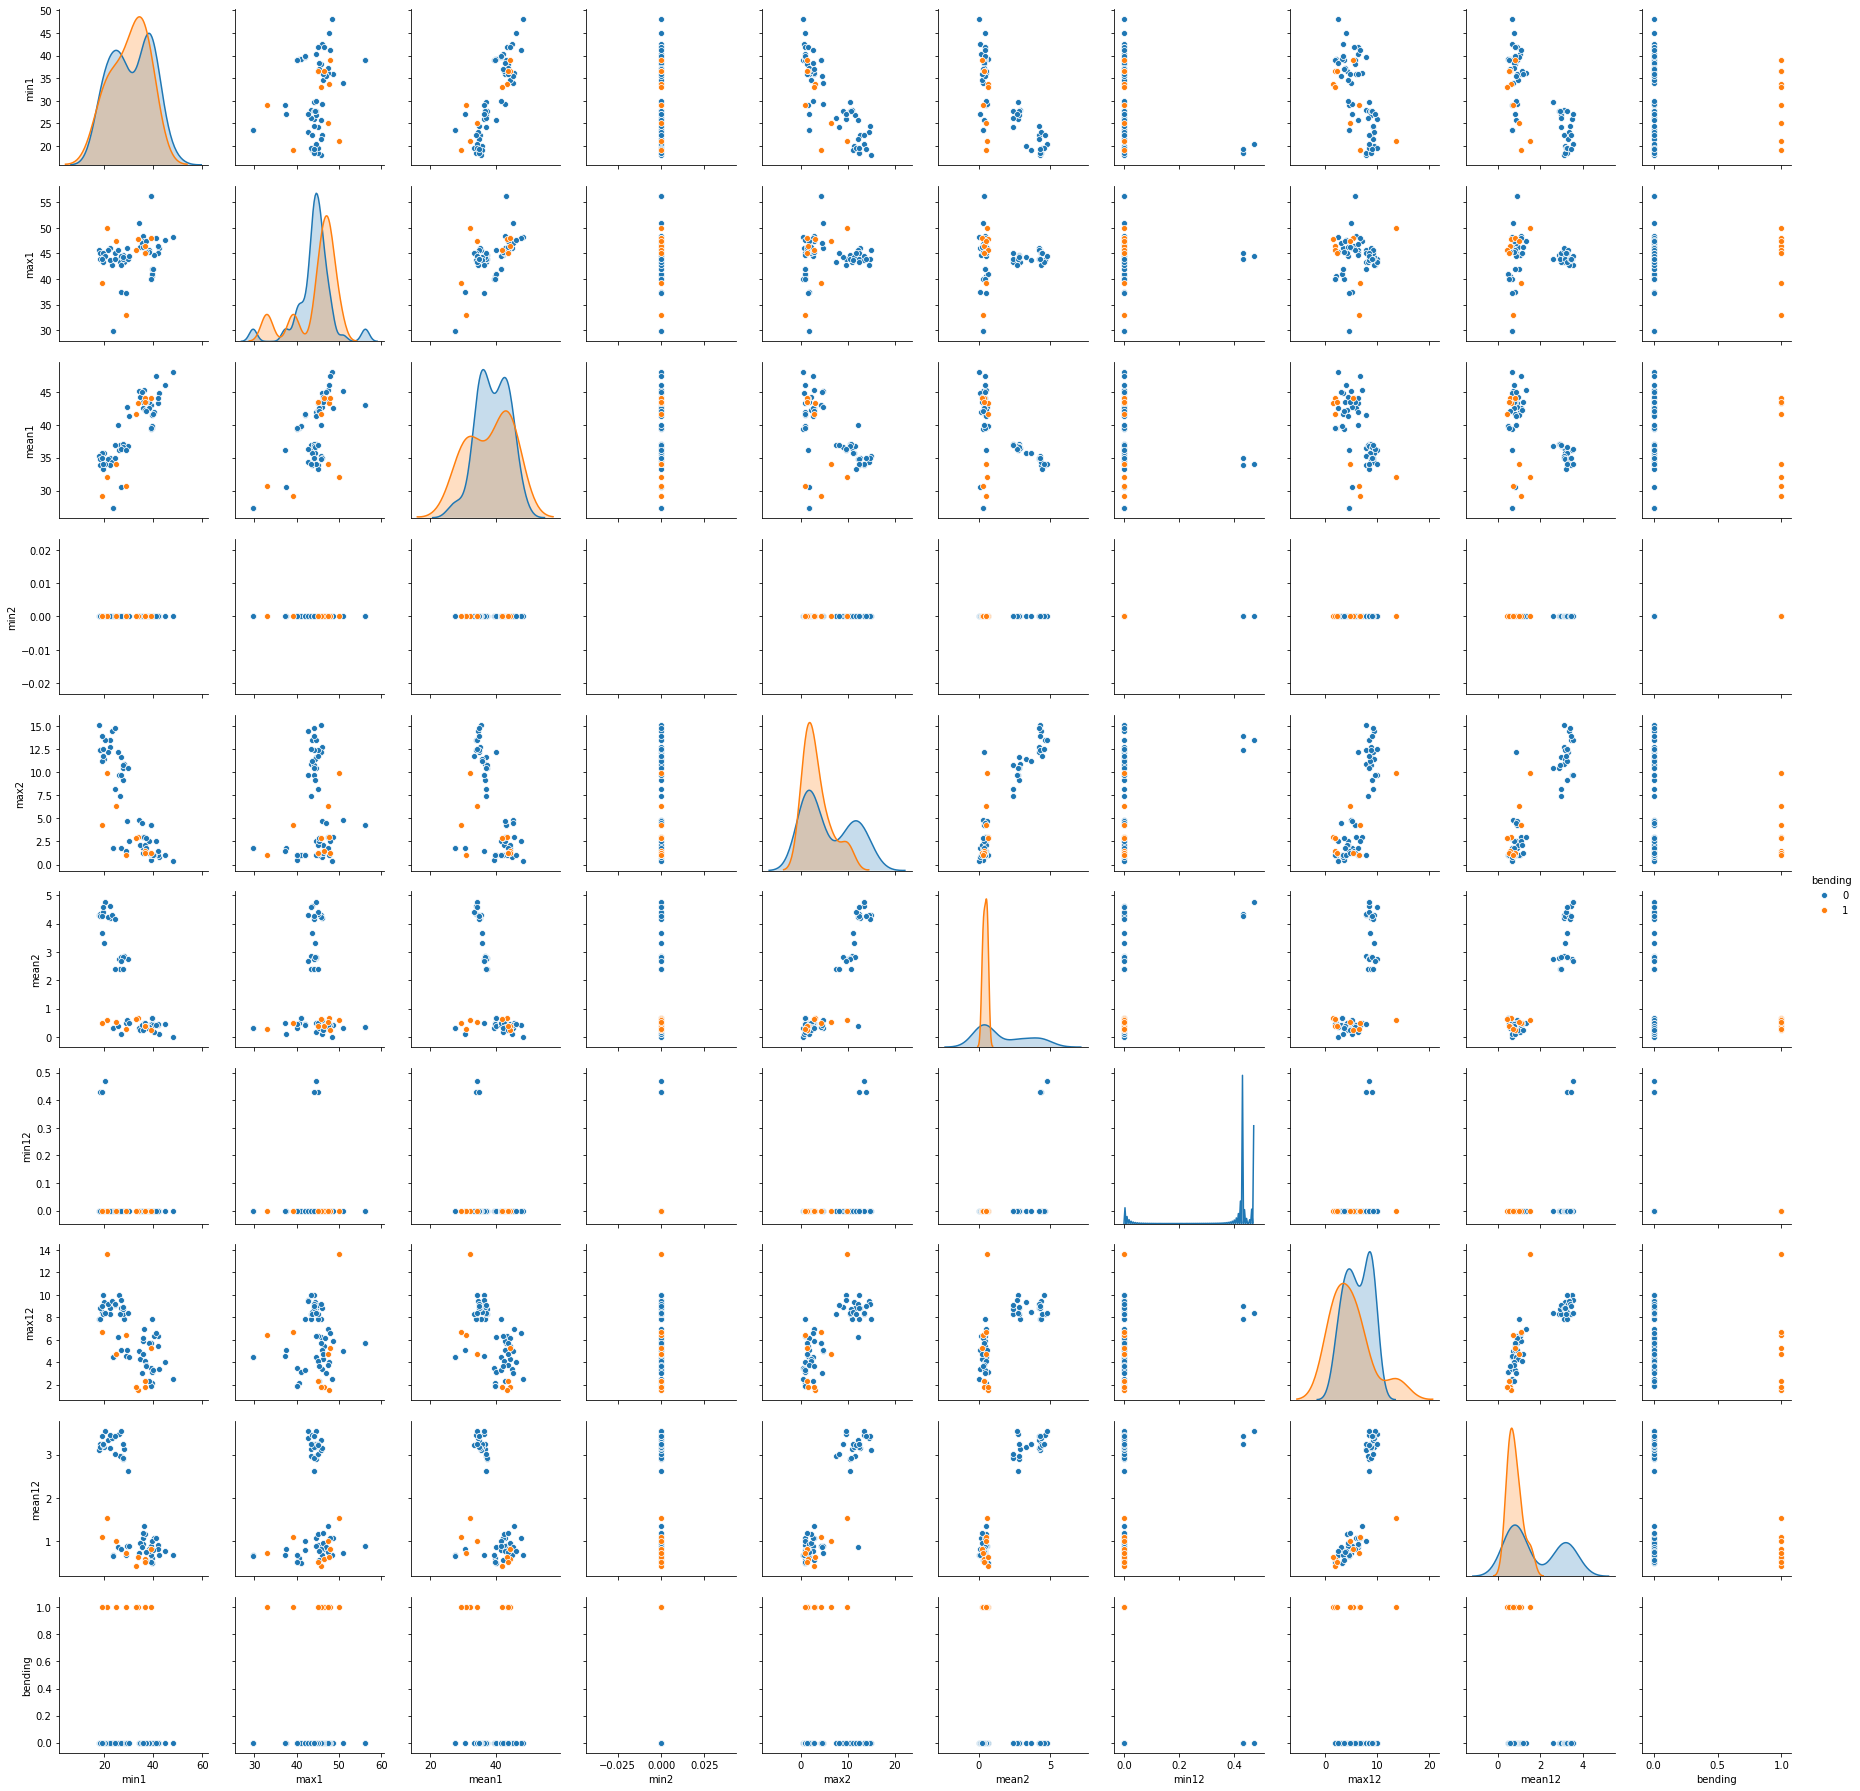

In [10]:
#select time series 1, 2, and 12's min,max,mean data from training set
new_train_time_domain_features=new_train_time_domain_features[['min1','max1','mean1','min2','max2','mean2','min12','max12','mean12']]
new_train_time_domain_features['bending']=[1]*9+[0]*60 #bending or not bending
sns.pairplot(new_train_time_domain_features,hue='bending')
print('                                                scatterplot')
plt.show()

#### break each time series in training set into l time series, and then use logistic regression to solve binary classification problem, for each l value cacluate p-values and refit model, use fold cross-validation to determine the best value of (l,p)

In [11]:
##Reference online resources
#create new test set which break each time series in original training set into l(1---20) time series
dataframes=np.array(test_dict.values())
dataframes=dataframes.tolist() #array to list

l_test_dict = {}
for l in range(1,21):
    content = []
    for dataframe in dataframes:
        dataframe = dataframe.drop(["time"], axis = 1)
        dataframe = np.array_split(dataframe,l) #Split an array into multiple sub-arrays

        df = pd.DataFrame()
        for index,value in enumerate(dataframe,1): #enumerate()  allows us to loop over something and have an automatic counter
            value.reset_index(drop=True,inplace=True) #reset index
            for column in value.columns:
                df[column + "_" + str(index+1)] = value[column]
        
        # time domain features after test set be split
        time_domain_features_list = []
        column_names = []
        for index, column in enumerate(df.columns): 
            Min=df[column].min()
            time_domain_features_list.append(Min)
            column_names.append(column + "_min")
            
            Max=df[column].max()
            time_domain_features_list.append(Max)
            column_names.append(column + "_max")
            
            Mean=df[column].mean()
            time_domain_features_list.append(Mean)
            column_names.append(column + "_mean")
            
            Median=df[column].median()
            time_domain_features_list.append(Median)
            column_names.append(column + "_median")
            
            Standard_Deviation=df[column].std()
            time_domain_features_list.append(Standard_Deviation)
            column_names.append(column + "_std")
            
            First_quartile=df[column].quantile(q=0.25)
            time_domain_features_list.append(First_quartile)
            column_names.append(column + "_1st_quart")
            
            Third_quartile=df[column].quantile(q=0.75)
            time_domain_features_list.append(Third_quartile)
            column_names.append(column + "_3rd_quart")

        content.append(time_domain_features_list)
    new_df = pd.DataFrame(content, columns=column_names)
    new_df["bending"] = [1]*2+[0]*3+[1]*2+[0]*12 # without order
    l_test_dict[l] = new_df

In [12]:
##Reference online resources
#create new training set which break each time series in original training set into l(1---20) time series
dataframes=np.array(train_dict.values())
dataframes=dataframes.tolist()

l_train_dict = {}
for l in range(1,21):
    content = []
    for dataframe in dataframes:
        
        dataframe = dataframe.drop(["time"], axis = 1)
        dataframe = np.array_split(dataframe, l) #Split an array into multiple sub-arrays
        
        df = pd.DataFrame()
        for index,value in enumerate(dataframe,1): #enumerate()  allows us to loop over something and have an automatic counter
            value.reset_index(drop=True,inplace=True) #reset index
            for column in value.columns:
                df[column + "_" + str(index+1)] = value[column]
        
        # time domain features after training set be split
        time_domain_features_list = []
        column_names = []
        for index, column in enumerate(df.columns):
            Min=df[column].min()
            time_domain_features_list.append(Min)
            column_names.append(column + "_min")
            
            Max=df[column].max()
            time_domain_features_list.append(Max)
            column_names.append(column + "_max")
            
            Mean=df[column].mean()
            time_domain_features_list.append(Mean)
            column_names.append(column + "_mean")
            
            Median=df[column].median()
            time_domain_features_list.append(Median)
            column_names.append(column + "_median")
            
            Standard_Deviation=df[column].std()
            time_domain_features_list.append(Standard_Deviation)
            column_names.append(column + "_std")
            
            First_quartile=df[column].quantile(q=0.25)
            time_domain_features_list.append(First_quartile)
            column_names.append(column + "_1st_quart")
            
            Third_quartile=df[column].quantile(q=0.75)
            time_domain_features_list.append(Third_quartile)
            column_names.append(column + "_3rd_quart")

        content.append(time_domain_features_list)
    new_df = pd.DataFrame(content, columns=column_names)
    new_df["bending"] = [1]*5 + [0]*12+[1]*4+[0]*48  #without order
    l_train_dict[l] = new_df

In [13]:
# caculate the CV score of the i-th subset of features.
l_score={}
best_features={}
for l in range(1,21):
    x_train=l_train_dict[l].drop(['bending'],axis=1)
    y_train=l_train_dict[l]['bending']
    
    rfecv=RFECV(estimator=LogisticRegression(), cv=StratifiedKFold(5),scoring='accuracy')
    rfecv.fit(x_train,y_train)
    
    features=[]
    for index,column in enumerate(x_train.columns):
        if rfecv.support_[index]==True:  #check which features are selected
            features.append(column)
    best_features[l]=features
    l_score[l]=rfecv.grid_scores_[rfecv.n_features_-1]
    p=rfecv.n_features_
    print('l=',l,'accuarcy=',l_score[l],'the number of p=',p)

l= 1 accuarcy= 0.9571428571428571 the number of p= 9
l= 2 accuarcy= 0.9571428571428571 the number of p= 6
l= 3 accuarcy= 0.9571428571428573 the number of p= 2
l= 4 accuarcy= 0.9571428571428573 the number of p= 4
l= 5 accuarcy= 0.9571428571428571 the number of p= 4
l= 6 accuarcy= 0.9428571428571428 the number of p= 2
l= 7 accuarcy= 0.9571428571428571 the number of p= 6
l= 8 accuarcy= 0.9571428571428571 the number of p= 4
l= 9 accuarcy= 0.9571428571428571 the number of p= 4
l= 10 accuarcy= 0.9571428571428571 the number of p= 7
l= 11 accuarcy= 0.9714285714285715 the number of p= 5
l= 12 accuarcy= 0.9571428571428571 the number of p= 4
l= 13 accuarcy= 0.9714285714285715 the number of p= 10
l= 14 accuarcy= 0.9571428571428573 the number of p= 2
l= 15 accuarcy= 0.9714285714285715 the number of p= 26
l= 16 accuarcy= 0.9571428571428571 the number of p= 9
l= 17 accuarcy= 0.9571428571428571 the number of p= 5
l= 18 accuarcy= 0.9714285714285715 the number of p= 11
l= 19 accuarcy= 0.9714285714285715

In [14]:
# get the l of max score
Max_l_score = 0
ls=[]
for optional_l,val in l_score.items():
    if Max_l_score < float(val):
        Max_l_score = float(val)

for optional_l,value in l_score.items():
    if(value == Max_l_score):
        ls.append(optional_l)
print('optional l:',ls,'\n')
best_feature_names=best_features[ls[0]]
print('selected features of first optional 1: l=',ls[0],'\n',best_feature_names)

optional l: [11, 13, 15, 18, 19, 20] 

selected features of first optional 1: l= 11 
 ['vg_rss23_3_median', 'vg_rss23_3_1st_quart', 'avg_rss12_7_max', 'avg_rss12_8_3rd_quart', 'vg_rss23_11_min']


Answer: The wrong way to do time series cross validation is to use K-fold,it may encounter class imbalance problem, like K-fold does not contains time features, so stratified cross validation is a better way.

#### evaluate model ----- the confusion matrix and show the ROC and AUC for classifier on train data; the parameters of my logistic regression βi’s as well as the p-values associated with them

confusion matrix:
 [[60  0]
 [ 0  9]] 

AUC 1.0


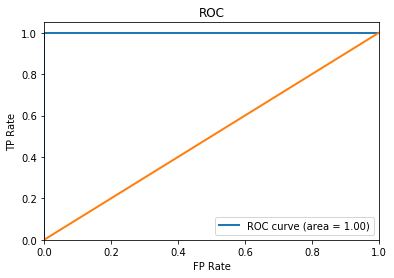

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.535068240876208e-11
            Iterations: 36
            Function evaluations: 43
            Gradient evaluations: 36
parameters:
 vg_rss23_3_median        1.488140
vg_rss23_3_1st_quart     4.405338
avg_rss12_7_max         -2.643759
avg_rss12_8_3rd_quart   -1.345177
vg_rss23_11_min          3.039393
dtype: float64 

p-values:
 vg_rss23_3_median        0.999999
vg_rss23_3_1st_quart     0.999998
avg_rss12_7_max          1.000000
avg_rss12_8_3rd_quart    1.000000
vg_rss23_11_min          0.999995
dtype: float64


In [15]:
#the confusion matrix on train data
x_train = l_train_dict[ls[0]][best_feature_names]
y_train = l_train_dict[ls[0]][["bending"]]
x_test = l_test_dict[ls[0]][best_feature_names]
y_test = l_test_dict[ls[0]][["bending"]]

classifier = LogisticRegression() #logistic regression
classifier.fit(x_train, y_train)
pred = classifier.predict(x_train)
print('confusion matrix:\n',confusion_matrix(y_train, pred),'\n')


#show ROC and AUC
FP, TP, thresholds = roc_curve(y_train, pred)
roc_auc = auc(FP, TP)
print('AUC',roc_auc)

plt.figure()
plt.plot(FP, TP, lw=2,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


# the parameters of my logistic regression βi’s as well as the p-values associated with them
logistic = sm.Logit(y_train, x_train)
logistic_model=logistic.fit_regularized()
print('parameters:\n',logistic_model.params,'\n')
print('p-values:\n',logistic_model.pvalues)

#### test the classifier on test set 

In [16]:
# accuracy on the test set
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
score=classifier.score(x_test, y_test)
print('accuray=',score)

accuray= 0.9473684210526315


Answer: the accuracy on the test set is smaller than cross-validation accuracy on training set

<font color=black size=4 face=雅黑>(vi) Answer: my classes be well-separated to cause instability in calculating logistic regression parameters </font>

#### build logistic regression on case-control sampling, and adjust parameters, report confusion matrix, ROC, AUC 

Answer: from the confusion matrices, there are imbalanced classes

In [19]:
##Reference online resources
# case-control sampling
train_df = x_train
train_df['bending'] = [1]*5 + [0]*12+[1]*4+[0]*48

train_df_majority = train_df[train_df.bending==0]
train_df_minority = train_df[train_df.bending==1]

train_df_minority_upsampled = resample(train_df_minority, replace=True, n_samples=60)
train_df_upsampled = pd.concat([train_df_majority,train_df_minority_upsampled])
train_df_upsampled.bending.value_counts()
train_df_upsampled

,vg_rss23_3_median,vg_rss23_3_1st_quart,avg_rss12_7_max,avg_rss12_8_3rd_quart,vg_rss23_11_min,bending
5,17.000,15.7300,43.33,37.5000,6.67,0
6,16.500,13.7300,42.00,38.6900,8.00,0
7,17.000,15.2475,42.50,39.3125,7.33,0
8,15.875,14.0000,46.25,38.0000,8.75,0
9,15.460,13.6275,51.25,37.8125,8.00,0
10,15.250,13.6275,41.00,38.0000,7.67,0
11,15.125,13.3100,45.00,40.4875,7.00,0
12,16.125,14.4375,45.50,38.8125,8.75,0
13,15.750,13.0000,41.00,36.8750,6.00,0
14,15.625,13.1875,39.75,39.0825,7.33,0


confusion matrix:
 [[60  0]
 [ 0 60]] 

AUC 1.0


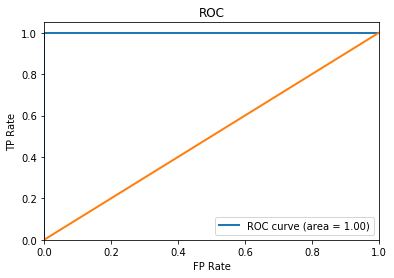

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4398965735209575e-10
            Iterations: 42
            Function evaluations: 50
            Gradient evaluations: 42
parameters:
 vg_rss23_3_median        2.920931
vg_rss23_3_1st_quart     4.178053
avg_rss12_7_max         -1.407643
avg_rss12_8_3rd_quart   -2.933479
vg_rss23_11_min          2.048634
dtype: float64


In [22]:
#the confusion matrix on case-control sampling
Y = train_df_upsampled[['bending']]
X = train_df_upsampled.drop('bending', axis=1)

classifier_1 = LogisticRegression() #logistic regression
classifier_1.fit(X, Y)
pred_1 = classifier_1.predict(X)
print('confusion matrix:\n',confusion_matrix(Y, pred_1),'\n')


#show ROC and AUC
FP, TP, thresholds = roc_curve(Y, pred_1)
roc_auc = auc(FP, TP)
print('AUC',roc_auc)

plt.figure()
plt.plot(FP, TP,lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


# the parameters of my logistic regression 
logistic = sm.Logit(Y, X)
logistic_model=logistic.fit_regularized()
print('parameters:\n',logistic_model.params)

### Binary Classification Using L1-penalized logistic regression 

#### repeat 1.3.1.3 using L1-penalized logistic regression 

In [23]:
l_score = {}
for l in range(1,21):
    x_train = l_train_dict[l].drop(["bending"], axis=1)
    y_train = l_train_dict[l]["bending"]

    #L1-penalized logistic regression
    classifier = LogisticRegressionCV(cv=5, penalty="l1", solver="liblinear")
    classifier.fit(x_train, y_train)
    score = classifier.score(x_train, y_train) 
    l_score[l] = score
    print('l=',l,'accuarcy=',l_score[l])

l= 1 accuarcy= 1.0
l= 2 accuarcy= 1.0
l= 3 accuarcy= 1.0
l= 4 accuarcy= 1.0
l= 5 accuarcy= 1.0
l= 6 accuarcy= 1.0
l= 7 accuarcy= 1.0
l= 8 accuarcy= 1.0
l= 9 accuarcy= 1.0
l= 10 accuarcy= 1.0
l= 11 accuarcy= 1.0
l= 12 accuarcy= 1.0
l= 13 accuarcy= 1.0
l= 14 accuarcy= 1.0
l= 15 accuarcy= 1.0
l= 16 accuarcy= 1.0
l= 17 accuarcy= 1.0
l= 18 accuarcy= 1.0
l= 19 accuarcy= 1.0
l= 20 accuarcy= 1.0


<font color=black size=4 face=雅黑>(ii) Answer: the accuracy score for L1-penalized is more for all values of l, so the L1-penalized performs better, and easy to inplement </font>

### Multi-class Classification 

#### find the best l to build L1-penalized multinomial regression model to classify all activities in training set; reprot test error; confusion matrices, ROC, AUC 

In [24]:
l_error = {}
for l in range(1,21):
    x_train = l_train_dict[l].drop(["bending"], axis=1)
    y_train = l_train_dict[l][["bending"]]
    y_train["clazz"] = [1]*5 + [2]*12 + [1]*4 + [3]*12 + [4]*12 + [5]*12 + [6]*12
    y_train = y_train.clazz
    
    x_test = l_test_dict[l].drop(["bending"], axis=1)
    y_test = l_test_dict[l][["bending"]]
    y_test["clazz"] = [1]*2 + [2]*3 + [1]*2 + [3]*3 + [4]*3 + [5]*3 +[6]*3
    y_test = y_test.clazz
    
    classifier = LogisticRegressionCV(cv=5, penalty="l1", solver="liblinear")
    classifier.fit(x_train, y_train)
    test_error = 1 - classifier.score(x_test, y_test) 
    l_error[l] = test_error
    print('l=',l,'test error=',test_error)

l= 1 test error= 0.26315789473684215
l= 2 test error= 0.21052631578947367
l= 3 test error= 0.21052631578947367
l= 4 test error= 0.21052631578947367
l= 5 test error= 0.1578947368421053
l= 6 test error= 0.21052631578947367
l= 7 test error= 0.21052631578947367
l= 8 test error= 0.1578947368421053
l= 9 test error= 0.1578947368421053
l= 10 test error= 0.21052631578947367
l= 11 test error= 0.1578947368421053
l= 12 test error= 0.1578947368421053
l= 13 test error= 0.10526315789473684
l= 14 test error= 0.21052631578947367
l= 15 test error= 0.1578947368421053
l= 16 test error= 0.1578947368421053
l= 17 test error= 0.1578947368421053
l= 18 test error= 0.1578947368421053
l= 19 test error= 0.1578947368421053
l= 20 test error= 0.21052631578947367


In [25]:
#get the l of min l_error
Min_l_error=None
ls=[]
for optional_l,val in l_error.items():
    if Min_l_error is None or float(val)<Min_l_error:
        Min_l_error=float(val)
for optional_l,value in l_error.items():
    if (value==Min_l_error):
        ls.append(optional_l)
print('optional l=',ls,'test error=',l_error[ls[0]])

optional l= [13] test error= 0.10526315789473684


In [26]:
#confusion matrix
x_train = l_train_dict[ls[0]].drop(["bending"], axis=1)
y_train = l_train_dict[ls[0]][["bending"]]
y_train["clazz"] = [1]*5 + [2]*12 + [1]*4 + [3]*12 + [4]*12 + [5]*12 + [6]*12
y_train = y_train.clazz
    
x_test = l_test_dict[ls[0]].drop(["bending"], axis=1)
y_test = l_test_dict[ls[0]][["bending"]]
y_test["clazz"] = [1]*2 + [2]*3 + [1]*2 + [3]*3 + [4]*3 + [5]*3 +[6]*3
y_test = y_test.clazz

classifier_1=LogisticRegression()
classifier_1_model=classifier_1.fit(x_train,y_train)
pred_y_1 = classifier_1_model.predict(x_test)
CM=confusion_matrix(y_test, pred_y_1)
print('confusion matrix:\n',CM)

confusion matrix:
 [[3 0 0 0 0 1]
 [0 3 0 0 0 0]
 [0 0 2 0 1 0]
 [0 0 1 2 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


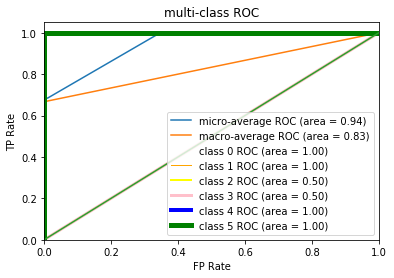

In [27]:
classes=[1,2,3,4,5,6]
label_train=label_binarize(y_train,classes)
label_test=label_binarize(y_test,classes)

classifier=OneVsRestClassifier(LogisticRegressionCV(cv=StratifiedKFold(5),penalty="l1",solver="liblinear"))
classifier.fit(x_train,label_train)
pred=classifier.predict(x_test)
classifier_score=classifier.fit(x_train,label_train).decision_function(x_test)

#Calculate ROC for each class
FP = {}
TP = {}
roc_auc = {}
n_classes = label_train.shape[1]
for i in range(n_classes):
    FP[i], TP[i],threshold= roc_curve(label_test[:, i],classifier_score[:, i])
    roc_auc[i] = auc(FP[i], TP[i])

##Reference online resources
#Compute micro-average ROC curve and ROC area
FP["mi"], TP["mi"],threshold= roc_curve(label_test.ravel(),classifier_score.ravel())
roc_auc["mi"] = auc(FP["mi"], TP["mi"])
FP["ma"] = np.unique(np.concatenate([FP[i] for i in range(n_classes)]))
TP["ma"] = np.zeros_like(FP["ma"])

for i in range(n_classes):
    TP["ma"] += interp(FP["ma"], FP[i], TP[i])
TP["ma"] /= n_classes
roc_auc["ma"] = auc(FP["ma"], TP["ma"])

#plot ROC
plt.figure()
plt.plot(FP["mi"], TP["mi"],label='micro-average ROC (area = {0:0.2f})'''.format(roc_auc["mi"]))
plt.plot(FP["ma"], TP["ma"],label='macro-average ROC (area = {0:0.2f})'''.format(roc_auc["ma"]))

colors = cycle(['red', 'orange', 'yellow','pink',"blue","green"])
lw=[0,1,2,3,4,5]
for i, color in zip(range(n_classes), colors): ##Reference online resources
    plt.plot(FP[i], TP[i], color=color,lw=lw[i],label='class {0} ROC (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('multi-class ROC')
plt.legend(loc="lower right")
plt.show()

#### using Naive Bayes' classifier to do culticlass classification

In [28]:
# Gaussian Naive Baye's classifier
G_l_score = {}
G_l_error = {}
for l in range(1,21):
    x_train = l_train_dict[l].drop(["bending"], axis=1)
    y_train = l_train_dict[l][["bending"]]
    y_train["result"] = [1]*5 + [2]*12 + [1]*4 + [3]*12 + [4]*12 + [5]*12 + [6]*12
    y_train = y_train.result
    
    G_classifier= GaussianNB() 
    scores = cross_val_score(G_classifier, x_train, y_train, cv=5)
    G_l_score[l] =  np.mean(scores)
    G_l_error[l] = 1 - G_l_score[l]

#get the l of min l_error and min l_error
Min_l_error=None
ls=[]
for optional_l,val in G_l_error.items():
    if Min_l_error is None or float(val)<Min_l_error:  ##Reference online resources
        Min_l_error=float(val)
for optional_l,value in G_l_error.items():
    if (value==Min_l_error):
        ls.append(optional_l)

print('l=',ls,'Gaussian error=',G_l_error[ls[0]])

l= [2] Gaussian error= 0.15053475935828886


In [29]:
#Gaussian confusion matrix
x_train = l_train_dict[ls[0]].drop(["bending"], axis=1)
y_train = l_train_dict[ls[0]][["bending"]]
y_train["clazz"] = [1]*5 + [2]*12 + [1]*4 + [3]*12 + [4]*12 + [5]*12 + [6]*12
y_train = y_train.clazz
    
x_test = l_test_dict[ls[0]].drop(["bending"], axis=1)
y_test = l_test_dict[ls[0]][["bending"]]
y_test["clazz"] = [1]*2 + [2]*3 + [1]*2 + [3]*3 + [4]*3 + [5]*3 +[6]*3
y_test = y_test.clazz

G_classifier_model=G_classifier.fit(x_train,y_train)
pred_y= G_classifier_model.predict(x_test)

print('confusion matrix:\n',confusion_matrix(y_test, pred_y))

confusion matrix:
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 2 1 0 0]
 [1 0 1 1 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


In [32]:
# Multinomial Naive Baye's classifier
M_l_score = {}
M_l_error={}
for i in range(1,21):
    x_train = l_train_dict[i].drop(["bending"], axis=1)
    y_train = l_train_dict[i][["bending"]]
    y_train["clazz"] = [1]*5 + [2]*12 + [1]*4 + [3]*12 + [4]*12 + [5]*12 + [6]*12
    y_train = y_train.clazz
       
    M_classifier = MultinomialNB()
    scores = cross_val_score(M_classifier, x_train, y_train, cv=5)
    M_l_score[i] =  np.mean(scores)
    M_l_error[i]=1-M_l_score[i]

#get the l of min l_error and min l_error
Min_l_error=None
ls=[]
for optional_l,val in M_l_error.items():
    if Min_l_error is None or float(val)<Min_l_error: ##Reference online resources
        Min_l_error=float(val)
for optional_l,value in M_l_error.items():
    if (value==Min_l_error):
        ls.append(optional_l)

print('l=',ls,'Multinomial error=',M_l_error[ls[0]])

l= [5] Multinomial error= 0.13190730837789677


In [33]:
#Multinomial confusion matrix
x_train = l_train_dict[ls[0]].drop(["bending"], axis=1)
y_train = l_train_dict[ls[0]][["bending"]]
y_train["result"] = [1]*5 + [2]*12 + [1]*4 + [3]*12 + [4]*12 + [5]*12 + [6]*12
y_train = y_train.result
    
x_test = l_test_dict[ls[0]].drop(["bending"], axis=1)
y_test = l_test_dict[ls[0]][["bending"]]
y_test["result"] = [1]*2 + [2]*3 + [1]*2 + [3]*3 + [4]*3 + [5]*3 +[6]*3
y_test = y_test.result

M_classifier_model=M_classifier.fit(x_train,y_train)
pred_y= M_classifier_model.predict(x_test)

print('confusion matrix:\n',confusion_matrix(y_test, pred_y))

confusion matrix:
 [[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 1 2 0 0]
 [0 0 1 2 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


<font color=black size=4 face=雅黑>(iii) Answer: Compare the test error, Multinomial Naive Baye's classifier is better for multi-class classification because it has higher accuracy, and lower test error </font>

<font color=black size=5 face=雅黑>ISLR 3.7.4 </font>

Answer:
#(a) The cubic resgression model is more flexible than linear regression, so cubic regression model have lower training RSS than linear regression model.
#(b) However, when the relationship between X and Y is linear, cubic regression model will overfitting, so the test RSS of cubic regression is higher than linear regression
#(c) The cubic resgression model is more flexible than linear regression, so cubic regression model have lower training RSS than linear regression model.
#(d) When the relationship between X and Y is not linear,if model's linearity is close to linear, the test RSS of simple regression will be lower and vice versa.